# Taller de Segmentación de Imágenes con autoencoder variacional

Este taller es la continuación del [Taller de segmentación de Imágenes](taller_1_autoencoders.ipynb).

En esta ocasión se va a tratar una arquitectura de red neuronal más compleja que el autoencoder estandar. Concretamente, se va a implementarun Autoencoder Variacional (VAE) que presenta algunos detalles de implementación interesantes y varias ventajas sobre el autoencoder corriente.

En un VAE la huella letente está formada por dos vectores, uno representa la media y otro la varianza de una serie de distribuciones normales. Para que estas distribuciones normales se encuentren normalizadas, se incluye un término de regulación a la función de pérdida que es la divergencia Kullback-Leibler. 

Por otro lado, una vez entrenado el VAE podremos generar nuevos ejemplos con el decodificador modificando los valores de la media y varianza de la huella latente.

![VAE](https://raw.githubusercontent.com/SergioHdezG/TallerSegmentacionMUVA/master/imagenes/vae.png)

# Dataset

En este notebook utilizamos un pequeño subconjunto del Cityscapes que es un dataset de imágenes recogidas en ciudades alemanas con una cámara situada en el parabrisas de un vehículo. Este dataset contiene las imágenes de segmentación anotadas manualmente y podemos encontrar clases como: coche, moto, camión, persona, carretera, acera, vegetación, edificios, semáforos...

![Cityscapes](https://raw.githubusercontent.com/SergioHdezG/TallerSegmentacionMUVA/master/imagenes/cityscapes.png)

Para el taller lo hemos reducido a solo 7 clases que son: vehículo, persona, suelo, edificios, vegetación, cielo y fondo (todo lo que no pertenezca a las otras clases)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras import backend as K
from tensorflow import keras
# from keras.engine import data_adapter
from utils import data_adapter

import os
import numpy as np
import matplotlib.pyplot as plt

2022-12-15 13:35:30.427717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shernandez/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-12-15 13:35:30.427737: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Preprocesado de datos
La siguiente celda solo es necesario ejecutarla si estás en google colab, desde binder omitela y omite también el enlace al dataset.

Este es un subconjunto del Cityscapes, añadelo a tu drive https://drive.google.com/file/d/1Y8LOzqYTyyWsEPqiPWdAZp3LSN8fHvSU/view?usp=sharing

En primer lugar tenemos que obtener acceso a nuestro google drive


In [2]:
# from google.colab import drive 
# drive.mount('/content/drive')

Buscamos la ruta del datset y lo descomprimimos en la carpeta de destino indicada

In [3]:
!unzip -u "datasets/minicityscapes.zip" -d "carpeta_destino"


unzip:  cannot find or open datasets/minicityscapes.zip, datasets/minicityscapes.zip.zip or datasets/minicityscapes.zip.ZIP.


Cargamos los nombres de fichero y los ordenamos

In [4]:
data_path = "../../carpeta_destino/minicityscapes"

x = os.listdir(os.path.join(data_path, "train_images_npy"))
y = os.listdir(os.path.join(data_path, "train_masks_npy"))

# Ordenamos los nombres delos ficheros por sequencia
x.sort(key=lambda x: (x.split("f")[-1].split("_")[0], int(x.split("_")[1])))
y.sort(key=lambda x: (x.split("f")[-1].split("_")[0], int(x.split("_")[1])))

x = np.array(x)
y = np.array(y)

x = x[:100]
y = y[:100]

print('Training size: ', len(x))
print(x[:5])
print(y[:5])

Training size:  26
['f1_0_img.npy' 'f1_1_img.npy' 'f1_2_img.npy' 'f1_3_img.npy'
 'f1_4_img.npy']
['f1_0_msk.npy' 'f1_1_msk.npy' 'f1_2_msk.npy' 'f1_3_msk.npy'
 'f1_4_msk.npy']


Cargamos los datos de entrenamiento en un numpy array.

In [5]:
x_train = [np.load(os.path.join(data_path, "train_images_npy", name)) for name in x]
y_train = [np.load(os.path.join(data_path, "train_masks_npy", name)) for name in y]
print('Training size: ', len(x))

Training size:  26


In [6]:
# Se convierte x_train a un numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)

Realizamos una visualización de los datos.

In [7]:
# Esta función reordena la clases de la máscara para visualizar mejor los datos

def reorder_visulization(img_label):
    mask_aux = np.copy(img_label[:, :, 0])
    img_label[:, :, 0] = img_label[:, :, 1]
    img_label[:, :, 1] = img_label[:, :, 3]
    mask_aux2 = np.copy(img_label[:, :, 2])
    img_label[:, :, 2] = img_label[:, :, 4]
    img_label[:, :, 3] = img_label[:, :, 5]
    img_label[:, :, 4] = img_label[:, :, 6]
    img_label[:, :, 5] = mask_aux2
    img_label[:, :, 6] = mask_aux
    return img_label

Input image shape:  (256, 512, 3)
Label image shape:  (256, 512, 7)


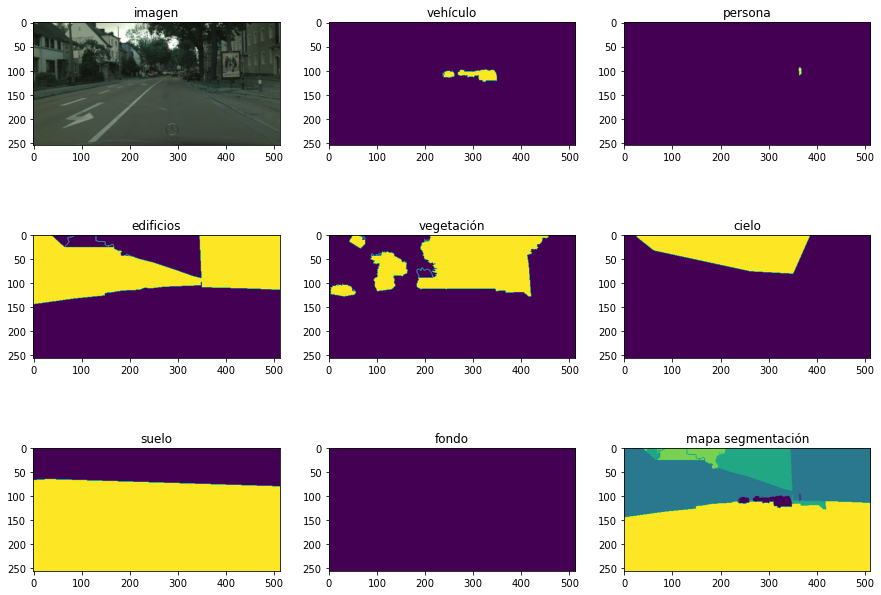

Train images range: : [ 0.0392156862745098 ,  1.0 ]
Train label images range: : [ 0.0 , 1.0 ]


In [8]:
n_img = np.random.randint(0, x_train.shape[0])
img_in = x_train[n_img]
img_label = y_train[n_img]

print('Input image shape: ', img_in.shape)
print('Label image shape: ', img_label.shape)

img_label = reorder_visulization(img_label)

plt.figure(figsize=(15, 15))
ax = plt.subplot(4, 3, 1)
ax.set_title("imagen")
plt.imshow(img_in)


# Mostramos cada máscara por separado
ax = plt.subplot(4, 3, 2)
ax.set_title("vehículo")
plt.imshow(img_label[:, :, 0])

ax = plt.subplot(4, 3, 3)
ax.set_title("persona")
plt.imshow(img_label[:, :, 1])

ax = plt.subplot(4, 3, 4)
ax.set_title("edificios")
plt.imshow(img_label[:, :, 2])

ax = plt.subplot(4, 3, 5)
ax.set_title("vegetación")
plt.imshow(img_label[:, :, 3])

ax = plt.subplot(4, 3, 6)
ax.set_title("cielo")
plt.imshow(img_label[:, :, 4])

ax = plt.subplot(4, 3, 7)
ax.set_title("suelo")
plt.imshow(img_label[:, :, 5])

ax = plt.subplot(4, 3, 8)
ax.set_title("fondo")
plt.imshow(img_label[:, :, 6])

# Generamos una imágen con todas las máscaras 
img_all_label = np.argmax(img_label, axis=-1) / 6.

ax = plt.subplot(4, 3, 9)
ax.set_title("mapa segmentación")
plt.imshow(img_all_label)

plt.show()

print("Train images range: : [", np.amin(img_in), ", ", np.amax(img_in), "]")
print("Train label images range: : [", np.amin(img_label[:, :, 0]), ",", np.amax(img_label[:, :, 0]), "]")

Alguna visualización adicional

Input image shape:  (256, 512, 3)
Label image shape:  (256, 512, 7)


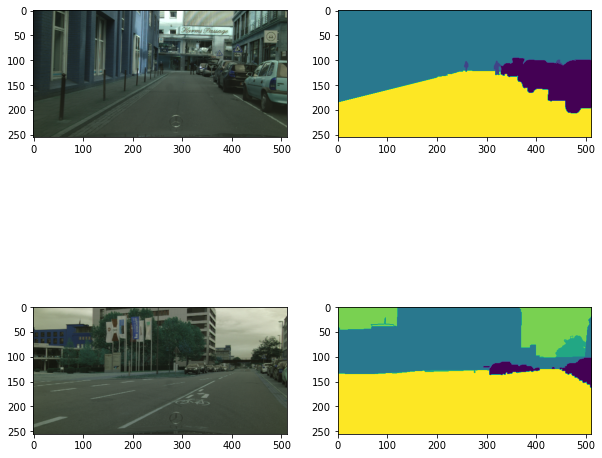

Train images range: : [ 0.050980392156862744 ,  0.9647058823529412 ]


In [9]:
n_img = np.random.randint(0, x_train.shape[0])
img_in = x_train[n_img]
img_label = y_train[n_img]

print('Input image shape: ', img_in.shape)
print('Label image shape: ', img_label.shape)

img_label = reorder_visulization(img_label)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(img_in)

# Generamos una imágen con todas las máscaras 
img_all_label = np.argmax(img_label, axis=-1) / 6.
plt.subplot(2, 2, 2)
plt.imshow(img_all_label)

n_img = np.random.randint(0, x_train.shape[0])
img_in = x_train[n_img]
img_label = y_train[n_img]

img_label = reorder_visulization(img_label)

plt.subplot(2, 2, 3)
plt.imshow(img_in)

# Generamos una imágen con todas las máscaras 
img_all_label = np.argmax(img_label, axis=-1) / 6.
plt.subplot(2, 2, 4)
plt.imshow(img_all_label)

plt.show()

print("Train images range: : [", np.amin(img_in), ", ", np.amax(img_in), "]")

Normalizamos los datos si fuese necesario.

In [10]:
# Normalizamos los datos de entrada en rango [0, 1]
# x_train = x_train / 255. # En este caso ya vienen normalizados por defecto

Las etiquetas de este conjunto de datos ya se encuentran en codificación one hot. En caso de utilizar un dataset que no se encuentre codificado en formato one hot podemos utilizar la siguiente instrucción para transformarlo.

In [11]:
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=7)  # to one hot encoding

Revisamos la forma y los valores de los datos. Las etiquetas en codificación one hot tienen que tener forma (h, w, 7)

In [12]:
img_in = x_train[0]
img_label = y_train[0]
print('Input image shape: ', img_in.shape)
print('Label image shape: ', img_label.shape)

print("Train images range: : [", np.amin(img_in), ", ", np.amax(img_in), "]")
print("Train label images range: : [", np.amin(img_label), ",", np.amax(img_label), "]")

Input image shape:  (256, 512, 3)
Label image shape:  (256, 512, 7)
Train images range: : [ 0.043137254901960784 ,  1.0 ]
Train label images range: : [ 0.0 , 1.0 ]


Separamos un subconjunto de los datos para test. En este caso no se nos da un conjunto de test y es por esto que vamos a extraerlo nosotros de los datos que tenemos.

In [13]:
# saparamos un subconjunto para test
test_split = 0.15
test_split = int(x_train.shape[0] * test_split)
test_idx = np.random.choice(x_train.shape[0], test_split, replace=False)  # Seleccionamos varios índices aleatorios
train_mask = np.array([False if i in test_idx else True for i in
                       range(x_train.shape[0])])  # Creamos una máscara para seleccionar los datos de entrenamiento

x_test = x_train[test_idx]  # Seleccionamos datos de test
y_test = y_train[test_idx]

x_train = x_train[train_mask]  # Seleccionamos datos de entrenamiento
y_train = y_train[train_mask]

print('Train samples: ', x_train.shape[0])
print('Test samples: ', x_test.shape[0])

Train samples:  23
Test samples:  3


Separamos un subconjunto de los datos para hacer validación.

In [14]:
# saparamos un subconjunto de validación

val_split = 0.05
val_split = int(x_train.shape[0] * val_split)
val_idx = np.random.choice(x_train.shape[0], val_split, replace=False)  # Seleccionamos varios índices aleatorios
train_mask = np.array([False if i in val_idx else True for i in range(x_train.shape[0])])  # Creamos una máscara para seleccionar los datos de entrenamiento

x_val = x_train[val_idx]  # Seleccionamos datos de validacón
y_val = y_train[val_idx]

x_train = x_train[train_mask]  # Seleccionamos datos de entrenamiento
y_train = y_train[train_mask]

print('Train samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

Train samples:  22
Validation samples:  1


# Autoencoder Variacional

Se puede dividir en dos componentes principales: el codificador y el decodificador.



1.   Codificador: Red neuronal que transforma la entrada y la comprime en un vector o huella latente de dimensiones reducidas.
2.   Decodificador: Red neuronal que transforma la huella latente en un vector de características de interes (reconstrucción/descompresión de datos, segmentación, imagen de profundidad)

En el autoencoder variacional la huella latente es una distribución normal multivariada. Esto se corresponde con la obtención de dos vectores, de los cuales uno guarda los valores de la media (μ) de cada distribución normal y el otro la varianza de cada uno (σ). 

A la hora de pasar los valores de la huella latente al decodificador del VAE, se realiza un muestreo sobre las distribuciones normales que forman la huella latente. Este paso es especialmente delicado ya que muestrear de una distribución normal no es una operación derivable y por lo tanto no nos permitiría entrenar la red. Para solventarlo se utiliza "el truco de la reparametrización" que implementamos más adelante en la función "sampling".

![VAE](https://raw.githubusercontent.com/SergioHdezG/TallerSegmentacionMUVA/master/imagenes/vae.png)


En este ejemplo vamos a construir un modelo de Keras a partir de los submodelos de codificador y decodificador.

In [15]:
def encoder(latent_dim, input_shape):
    inputs = Input(shape=input_shape, name='encoder_input')

    # Construimos el modelo de codificador
    x = Conv2D(filters=128,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(inputs)

    # x = MaxPooling2D((2, 2))(x)
    x = Conv2D(filters=128,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)

    # x = MaxPooling2D((2, 2))(x)
    x = Conv2D(filters=256,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)

    # x = MaxPooling2D((2, 2))(x)
    x = Conv2D(filters=256,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)

    x = Conv2D(filters=256,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)

    # Necesitamos la información de las dimensiones de la salida de la última
    # capa convolucional para poder reconstruir la imagen al tamaño correcto en
    # el decodificador
    last_conv_shape = K.int_shape(x)

    # Generamos la huella latente
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)

    z_mean = Dense(latent_dim, name='z_mean', activation='linear')(x)
    z_log_var = Dense(latent_dim, name='z_log_var', activation='linear')(x)

    # Par usar una función externa en un modelo de Keras tenemos que hacerlo a 
    # través de una capa Lambda. La función sampling realiza el truco de la reparametrización
    # z = Lambda(sampling, name='z')([z_mean, z_log_var])
    z = Sampling()([z_mean, z_log_var])

    # instantiate encoder model
    encoder = tf.keras.models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    return encoder, last_conv_shape

In [16]:
def decoder(latent_dim, last_conv_shape, out_channels):
    # Construimos el modelo de decodificador
    latent_input = Input(shape=(latent_dim,), name='z_sampled')

    # shape = 4*8*8 = 584
    x = Dense(last_conv_shape[1] * last_conv_shape[2] * last_conv_shape[3], activation='relu')(latent_input)
    # shape = 584 => (4, 8, 8)
    x = Reshape((last_conv_shape[1], last_conv_shape[2], last_conv_shape[3]))(x)

    x = Conv2DTranspose(filters=256,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    x = Conv2DTranspose(filters=256,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    # x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(filters=256,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    # x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(filters=128,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    # x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(filters=128,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    output = Conv2DTranspose(filters=out_channels,
                          kernel_size=3,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)  # Activación sigmoide para que las salidas estén en rango [0, 1]


    # instantiate decoder model
    decoder = tf.keras.models.Model(latent_input, output, name='decoder')
    decoder.summary()

    return decoder

Vamos a contruir un modelo de Keras con el Encoder y el Decoder.

In [17]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=0.5, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta  # Factor de importancia de la regulación (beta-VAE)

        self.acc = tf.keras.metrics.CategoricalAccuracy(name="acc")
        self.val_acc = tf.keras.metrics.CategoricalAccuracy(name="val_acc")

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")
        self.val_reconstruction_loss_tracker = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.val_kl_loss_tracker = keras.metrics.Mean(name="val_kl_loss")

        self.reconstruction_loss = None

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.acc,
            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_kl_loss_tracker,
        ]

    def train_step(self, data):
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            reconstruction = self.decoder(z, training=True)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction))
            )

        total_loss, kl_loss = vae_loss_func(reconstruction_loss, z_log_var, z_mean, beta=beta)

        grads = tape.gradient(reconstruction_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(beta*kl_loss)
        self.acc.update_state(y, reconstruction)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "beta*kl_loss": self.kl_loss_tracker.result(),
            "acc": self.acc.result()
        }

    def test_step(self, data):
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)


        # Compute predictions
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)

        # Updates the metrics tracking the loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(y, reconstruction))
        )

        total_loss, kl_loss = vae_loss_func(reconstruction_loss, z_log_var, z_mean, beta=beta)

        # Update the metrics.
        self.val_total_loss_tracker.update_state(total_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.val_kl_loss_tracker.update_state(beta*kl_loss)
        self.val_acc.update_state(y, reconstruction)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {
            "loss": self.val_total_loss_tracker.result(),
            "reconstruction_loss": self.val_reconstruction_loss_tracker.result(),
            "beta*kl_loss": self.val_kl_loss_tracker.result(),
            "val_acc": self.val_acc.result()
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

A la hora de muestrear de las distribuciones normales que forman la huella latente es necesario utilizar el "truco de la reparametrización" para que sea posible retropropagar el gradiente. Esto se debe a que muestrear de una distribución normal no es una operación derivable.

Con este fin, se introduce la variable "epsilon" que es un vector de valores que se obtienen muestreando de una distribución normal N(0, 1). El valor de epsilon se utiliza para hacer la selección de z mediante la ecuación: 

z = z_mean + var * epsilon

In [18]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

La pérdida en un VAE está compuesta por dos términos

1.   Pérdida de la reconstrucción: Esta mide cuanto se ajusta cada pixel de salida al valor de la etiqueta correspondiente.
2.   Término de regulación KL (Kullback–Leibler): Controla que el espacio latente forme un distribución normal multivariada centrada en cero.



In [19]:
def vae_loss_func(reconstruction_loss, z_log_var, z_mean, beta=0.5):
    # Vamos a calcular la Kullback-Leibler dirvegence entre dos gaussianas
    # KL = 1/2 {(std_0/std_1)^2 + (mu_1-mu_0)^2/std_1^2 - 1 + ln(st_1^2/st_0^2)}
    # Se simplifica teniendo en cuenta que:
    # mu_0 = 0; std_0 = 1; std_1 = e^{log(std_1^2)/2} = e^z_log_var
    kl_loss = - 0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

    # beta: factor de importancia de la regulación (beta-VAE)
    vae_loss = tf.reduce_mean(reconstruction_loss + beta * kl_loss)

    return vae_loss, kl_loss

Construimos el modelo de VAE.
Seleccionamos el número de canales en función del número de etiquetas.

In [20]:
input_shape = (256, 512, 3)
out_channels = 7
latent_dim = 2048
beta = 10

encoder, last_conv_shape = encoder(latent_dim, input_shape)
decoder = decoder(latent_dim, last_conv_shape, out_channels)
vae = VAE(encoder, decoder, beta)

vae.compile(optimizer=keras.optimizers.Adam(lr=1e-4))


2022-12-15 13:35:35.309080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 13:35:35.309577: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shernandez/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-12-15 13:35:35.309672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shernandez/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-12-15 13:35:35.309761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 128 3584        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 128, 128) 147584      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 64, 256)  295168      conv2d_1[0][0]                   
____________________________________________________________________________________________

/home/shernandez/anaconda3/envs/tf26/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### Entrenamos el VAE

Normalmente, en Keras y otras bibliotecas similares, tendríamos que los datos de entrada son x_train y se introduce como etiquetas y_train, tal que:


In [21]:
batch_size = 32
epochs = 100

vae.fit(x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(x_val, y_val))

2022-12-15 13:35:36.182957: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 1998533.1250 - reconstruction_loss: 1998532.2500 - beta*kl_loss: 0.9356 - acc: 0.1500 - val_loss: 90811.4688 - val_reconstruction_loss: 90807.9688 - val_beta*kl_loss: 3.4978 - val_val_acc: 0.2408
Epoch 2/100
1/1 [==============================] - 6s 6s/step - loss: 1997686.3750 - reconstruction_loss: 1997682.7500 - beta*kl_loss: 3.6422 - acc: 0.2397 - val_loss: 90785.4297 - val_reconstruction_loss: 90767.1094 - val_beta*kl_loss: 18.3228 - val_val_acc: 0.2806
Epoch 3/100
1/1 [==============================] - 6s 6s/step - loss: 1996709.3750 - reconstruction_loss: 1996690.3750 - beta*kl_loss: 18.9701 - acc: 0.3287 - val_loss: 90791.6875 - val_reconstruction_loss: 90717.1562 - val_beta*kl_loss: 74.5341 - val_val_acc: 0.3138
Epoch 4/100
1/1 [==============================] - 6s 6s/step - loss: 1995536.8750 - reconstruction_loss: 1995460.0000 - beta*kl_loss: 76.8945 - acc: 0.3912 - val_loss: 90903.2969 - val_reconstructio


KeyboardInterrupt



Salvamos el modelo. En este caso, es necesario guardar el Codificador y Decodificador por separado por dos motivos:


1.   Nos puede interesar utilizar en el futuro usar solo una de las dos partes independientemente.
2.   La unión entre los dos es un poco especial ya que pasan tres tensores de uno a otro y hemos tenido que hacerlo de forma no "estandar". En este caso Keras da problemas al guardar el modelo completo de VAE.

Solo guardamos los pesos debido a que ya tenemos el modelo completo definido en el notebook.



In [ ]:
# encoder_path = 'ruta.../taller_encoder.h5'
# decoder_path = 'ruta.../taller_decoder.h5'

# save_name = encoder_path
# encoder.save_weights(save_name)
# print("Encoder saved  to disk")

# save_name = decoder_path
# decoder.save_weights(save_name)
# print("Decoder saved  to disk")

Para cargar el VAE, tendremos que cargar ambos submodelos (codificador y decodificador). En caso de que no hayamos construido anteriormente el VAE tendremos que hacerlo antes de cargar os pesos con la función "build_model"

In [ ]:
# encoder_path = 'ruta.../taller_encoder.h5'
# decoder_path = 'ruta.../taller_decoder.h5'

# # Si no se hubiese creado el modelo todavía habria que crear uno nuevo con la siguiente linea
# # encoder, decoder, vae = build_model(input_shape, out_channels, latent_dim)

# # load weights into new model
# encoder.load_weights(encoder_path)

# # load weights into new model
# decoder.load_weights(decoder_path)

# # Si fuesemos a reentrenar necesitariamos compilamos el modelo de nuevo
# # vae.compile(optimizer='adam')

# Testing


La función evaluate realiza un predict sobre cada entrada del conjunto de test y extrae las métricas que hayamos indicado al compilar el modelo.

In [ ]:
vae.evaluate(x_test, y_test, batch_size=batch_size)

Por último, vamos a visualizar algunos de los resultados. 

La siguiente celda selecciona varias imágenes aleatorias y muestra su salida.

In [ ]:
figsize = 5
num_examples_to_generate = figsize*figsize
fig = plt.figure()
fig.suptitle('Resultados segmentación')
examples_index = np.random.choice(x_test.shape[0], figsize*2)
examples = x_test[examples_index]
z_mean, z_log_var, z = encoder.predict(examples)
predictions = decoder.predict(z_mean)


predictions = np.argmax(predictions, axis=-1) / 6.

plt.figure(figsize=(20, 10))
for i in range(figsize*2):

    plt.subplot(4, figsize, i+1)
    plt.imshow(examples[i])
    plt.subplot(4, figsize, i + 1 + figsize*2)
    plt.imshow(predictions[i])

plt.axis('off')
plt.show()

Una característica interesande de los VAE es que su decodificador es un modelo generador. Podemos crear una huella latente y ajustar sus parámetros para obtener imágenes nuevas.

Por ejemplo con una red que segmente el tráfico, podríamos crear imagenes de segmentación de nuevas situaciones y a su vez utilizarlas para entrenar otro algoritmo en el manejo de un vehículo autónomo.

En la celda siguiente se muestrean varias huellas latentes sobre una distribución normal para crear nuevos ejemplos.



In [ ]:
random_vector_for_generation = np.random.normal(size=(num_examples_to_generate, latent_dim))

predictions = decoder.predict(random_vector_for_generation)

predictions = np.argmax(predictions, axis=-1) / 6.
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Nuevos ejemplos generados')
for i in range(num_examples_to_generate):
    plt.subplot(figsize, figsize, i+1)
    plt.imshow(predictions[i])
plt.axis('off')
plt.show()